In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def dfdt(r, coeffs):
    '''
    Returns dx1/dt, dx2/dt, dx3/dt
    '''
    # Current position
    #r = np.ravel(r)
    x1 = r[0]
    x2 = r[1]
    x3 = r[2]
    
    # Extract coefficients
    A = coeffs[0]
    B = coeffs[1]
    C = coeffs[2]
    
    # Calculate the derivative
    dx1 = -A*x1  + A*x2
    dx2 = +B*x1  - x1*x3 - x2
    dx3 = +x1*x2 - C*x3
    
    return np.array([dx1, dx2, dx3], float)

def advance_time(r, coeffs, h):
    '''
    Calculate the state of the system at time t+1 using RK4
    
    Inputs:
        r - the state
        coeffs - the standard Lorenz system coefficients
        h - timstep
    '''
    
    # Calculate Runge-Kutta4 coefficients
    k1 = h*dfdt(r, coeffs)
    k2 = h*dfdt(r+0.5*k1, coeffs)
    k3 = h*dfdt(r+0.5*k2, coeffs)
    k4 = h*dfdt(r+k3, coeffs)
    
    # Update current position
    r += (k1 + 2*k2 + 2*k3 + k4)/6
    
    return r

In [156]:
## Background error variance
var_b = 1   
B_struct = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]])
B_cov = var_b * B_struct

# Note: dont have usehigh order scheme
# note forget about Q
## Model error covariance (ie: process noise), from Evensen 1997
Q = np.zeros((3,3))
Q[0,0] = 0.1491
Q[0,1] = 0.1505
Q[0,2] = 0.0007
Q[1,0] = 0.1505
Q[1,1] = 0.9048
Q[1,2] = 0.0014
Q[2,0] = 0.0007
Q[2,1] = 0.0014
Q[2,2] = 0.9180
# Qsqrt_cov = np.linalg.cholesky(Q)
L, V = np.linalg.eig(Q)
Qsqrt_cov = V*np.sqrt(L)    # TODO: Why this?

## Misc errors which I do not understand yet but need to run the system
varobs = 3   # Observation error variance
svar = 0.3

## Measurement covariance
sobs = np.sqrt(varobs)
R_struct = np.eye(3)
R = varobs * R_struct
L, V = np.linalg.eig(R)
Msqrt_cov = V*np.sqrt(L)



## Model setup  (Do not change)
N_state = 3 # Number of state variables
MO = 3      # Number of measurement variables

A_lor = 10  # Default Lorenz system parameters
B_lor = 28
C_lor = 8/3
coeffs = np.array([A_lor, B_lor, C_lor],float)

# Numerical parameters
# Constants_______________________
t0 = 0          # sec, initial time
tf_assim = 3    # sec, final time   of forecast
h_sys = 0.02    # sec, timestep for system dynamics
t_sys = np.arange(t0,tf_assim,h_sys)
N_sys = len(t_sys)               # Number of system timesteps
print (f'N states = {N_sys}')

N states = 150


#### Setup Model

N obs = 5  [increments of 30]


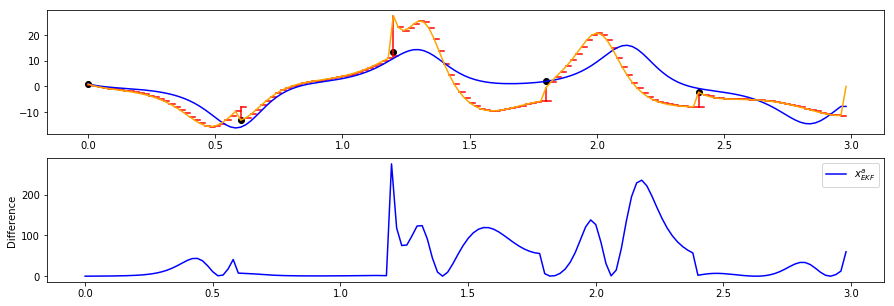

In [185]:
# ======================== TWEAK ========================
# Change Number of observations.
# Number of dynamics updates per measurement
dyn2meas = 30 #(subject to change)
Q_changes = Qsqrt_cov.copy() * 0.001 # Q-value (not Q-matrix made above)
Pa = B_cov.copy() * .05 # initial Background-covariance
R_changes = Msqrt_cov.copy() # initial obs-covariance
# ========================================================

h_obs = h_sys * dyn2meas     # sec; an observation is generated every h_obs sec
t_obs = np.arange(t0,tf_assim,h_obs)     # time stamps for observations
N_obs = len(t_obs)               # Number of observations
times_obs = np.arange(t0,N_sys,dyn2meas)
print (f'N obs = {N_obs}  [increments of {dyn2meas}]')

# default input parameters, she uses 'astr' name
x_true = np.zeros([N_state, N_sys])  # True history of x1 (without any noise)
x1_0 = 1.5
x2_0 = -1.5
x3_0 = 25.5
## Iterate through time and simulate dynamics
r = np.array([[x1_0, x2_0, x3_0]], float).T   # "Current" position

## Set ICs
x_true[:,0] = np.squeeze(r)

for i in range(1,N_sys):
    x_true[:,i] = advance_time(x_true[:,i-1], coeffs, h_sys)

# OBSERVATIONS
y = np.zeros([MO, N_obs])  # Measurements of x1 (with measurement noise)

for i in range(N_obs):
    # this reads in states from 0 to 300 in increments of 20 to get even spread of obseravations
    # [:,np.newaxis] makes dimensions from 3, to 3x1.
    curr_state = x_true[:,i*dyn2meas][:,np.newaxis]
    # for each state selected, obs = Measurement covariance + randomness
    y[:,i] = np.squeeze(curr_state + Msqrt_cov @ np.random.randn(3,1))


## Set up necessary matrixies
# keep constant
A,B,C = coeffs

def M_LTM(xa,Pa,Q):
    x1, x2, x3 = xa[0,0], xa[1,0], xa[2,0]
    M = np.array([          # The tangent linear model evaluated at x=xa
        [-A_lor  ,  A_lor  ,  0.0],
        [B_lor-x3, -1.0,  -x1],
        [x2  , x1  ,  -C_lor]])
    Pf = M @ Pa @ M.T + Q_changes  # Forecast covar
    return Pf

# H is linear here
H = np.eye(3)
I = np.eye(3)
y_mat = np.matrix(y)

## Storage matrices.
xf_EKF = np.matrix(np.zeros([3, N_sys]))
Pf_EKF = np.zeros(shape=[3,3,N_sys])
xa_EKF = np.matrix(np.zeros([3, N_sys]))
Pa_EKF = np.zeros(shape=[3,3,N_sys])


# initial state (by obs)
xa = np.array([[y[0,0], y[1,0], y[2,0]]], float).T
xf_EKF[:,0] = y_mat[:,0]
Pf_EKF[:,:,0] = Pa
xa_EKF[:,0] = y_mat[:,0]
Pa_EKF[:,:,0] = Pa


plt.figure(figsize=[15,5])
plt.subplot(2,1,1)

xa_CONTROL = xa_EKF.copy()
y_pt = -1
for i in range(t0,N_sys-1): # i is 0 to 150.
        
    xa = np.array(xa, float)
    xf = advance_time(xa, coeffs, h_sys) # Forecast next step    
    
    s0 = (i)*h_sys
    s1 = (i+1)*h_sys
    plt.plot([s0,s1],[xa[0],xf[0]],color='red')
    
    
    Pf = M_LTM(xa,Pa,Q)
    Pa = Pf.copy() # no update
    xa_EKF[:,i], xf_EKF[:,i], Pa_EKF[:,:,i], Pf_EKF[:,:,i] = xa.copy(),xf.copy(),Pa.copy(),Pf.copy()
    xa_CONTROL[:,i] = xa.copy()
    
    if i in times_obs:
        y_pt += 1
        Y = y_mat[:,y_pt]
        ## Update
        K = Pf @ H.T @ np.linalg.inv(R + H@Pf@H.T)  # Kalman gain
        xa = xf + K @ (Y - H @ xf)   # Update mean
        Pa = (I - K @ H) @ Pf   # Update covar
        xa_EKF[:,i], xf_EKF[:,i], Pa_EKF[:,:,i], Pf_EKF[:,:,i] = xa.copy(),xf.copy(),Pa.copy(),Pf.copy()
        
        s0 = (i)*h_sys
        s1 = (i+1)*h_sys
        #show update
        #plt.plot([s0,s0],[xf_EKF[0,i],xa_EKF[0,i]],color='red')
        plt.plot([s0,s0],[xf[0],xa[0]],color='red')
        #show forecast
        #plt.plot([s0,s1],[xa[0],xf[0]],color='red')
        #print ([xa-xf])

for i in range(1):
    plt.plot(t_sys, x_true[i,:],color='blue',label='$x_{true}$')
    plt.scatter(t_obs, y[i,:],color='black',label='Obs')
    plt.plot(t_sys, np.ravel(xa_EKF[i,:]),color='orange',label='$x^a_{EKF}$')
    plt.subplot(2,1,2)
    plt.ylabel('Difference')
    DIFF = (x_true[i,:]-np.ravel(xa_EKF[i,:]))**2
    plt.plot(t_sys, DIFF,color='blue',label='$x^a_{EKF}$')
    #plt.plot(t_sys, np.ravel(xa_CONTROL[i,:]),color='green',label='$x^a_{EKF}$')
plt.legend();plt.show()

In [ ]:
'''Diff = (x_true[0,:] - np.ravel(xf_EKF[0,:]))
Cov = Pa_EKF[0,0,:]
np.sqrt(np.mean((Diff-Cov)**2))'''